In [4]:
# CÉLULA 1: Imports y Carga de Datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from scipy import sparse
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
import time

# Imports de modelos
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import tensorflow as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("🚀 Iniciando fase de entrenamiento...")

def load_processed_data(path='processed_data'):
    """Carga datos sparse y arrays numpy"""
    try:
        print(f"📂 Cargando datos desde '{path}'...")
        
        # Cargar matrices sparse
        X_train = sparse.load_npz(f'{path}/X_train_tfidf.npz')
        X_val = sparse.load_npz(f'{path}/X_val_tfidf.npz')
        X_test = sparse.load_npz(f'{path}/X_test_tfidf.npz')
        
        # Cargar etiquetas
        y_train = np.load(f'{path}/y_train.npy')
        y_val = np.load(f'{path}/y_val.npy')
        y_test = np.load(f'{path}/y_test.npy')
        
        print(f"✅ Datos cargados exitosamente.")
        print(f"   X_train shape: {X_train.shape} (Sparse)")
        print(f"   y_train shape: {y_train.shape}")
        return X_train, X_val, X_test, y_train, y_val, y_test
        
    except FileNotFoundError:
        print("❌ Error: No se encuentran los archivos. Asegúrate de haber ejecutado la fase de exportación.")
        return None

# Ejecutar carga
X_train, X_val, X_test, y_train, y_val, y_test = load_processed_data()

🚀 Iniciando fase de entrenamiento...
📂 Cargando datos desde 'processed_data'...
✅ Datos cargados exitosamente.
   X_train shape: (162451, 5000) (Sparse)
   y_train shape: (162451,)


# Modelos Clásicos (Naive Bayes y Regresión Logística)
Algo importante a considerar son los falsos negativos, es decir que se diagnostica como "no suicidio", cuando en realidad es suicidio, para proceder con un análisis y apoyo correcto del sujeto, y los falsos positivos, no habría mayor riesgo mas que perder dinero en apoyo innecesario, o un análisis más profundo.

En logistic regression, utilizando GridSearch, se buscaron los parámetros para F1, para encontrar un mejor balance entre precisión y recall, para no tener falsos negativos pero 
tampoco saturar a los psicólogos con falsos positivos.


🤖 1. Entrenando Naive Bayes...
✅ Naive Bayes - Acc: 0.8958 | F1: 0.9010 | Recall: 0.9478
   📉 Generando gráfica de Costo para: Curva de Aprendizaje - Naive Bayes...


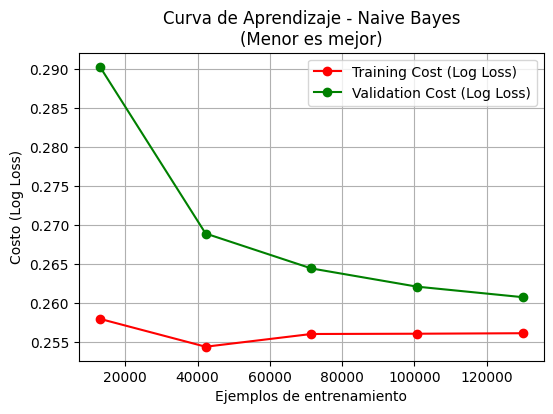


📑 Matriz de Confusión (Naive Bayes):


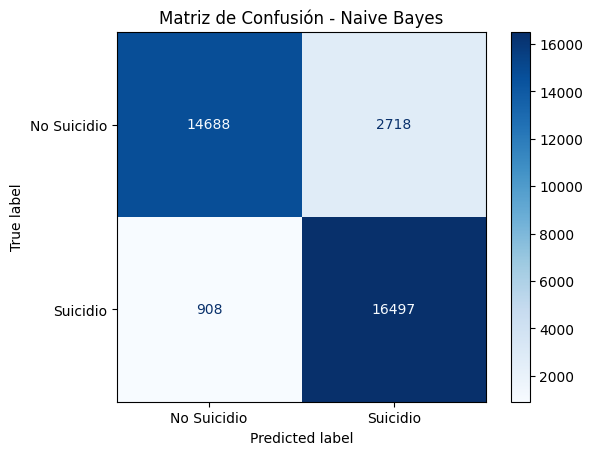


🤖 2. Optimizando Logistic Regression (GridSearch)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
✅ Búsqueda terminada en 16.58s
   🏆 Mejores parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
   📊 Accuracy: 0.9328
   📊 F1-Score: 0.9323
   ⚠️ Recall (Suicidio): 0.9254 (¡Crítico para este proyecto!)

📉 Generando Curva de Aprendizaje para Logistic Regression (COSTO)...
   📉 Generando gráfica de Costo para: Curva de Aprendizaje - Logistic Regression...


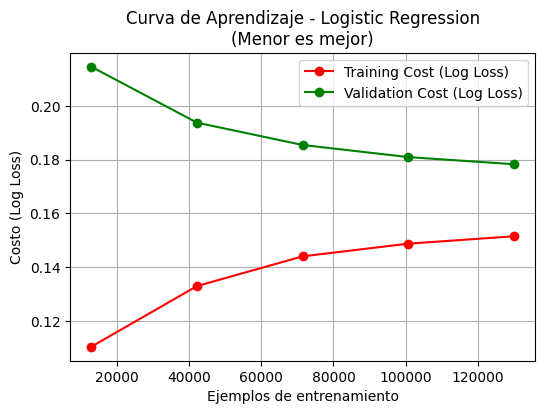


📑 Matriz de Confusión (Logistic Regression):


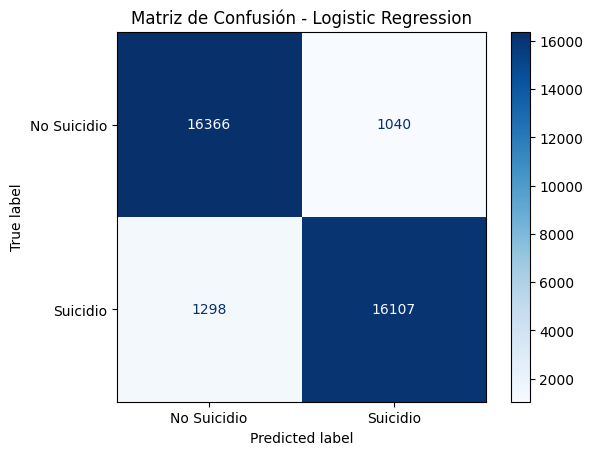


📈 Generando Comparación ROC Curves...


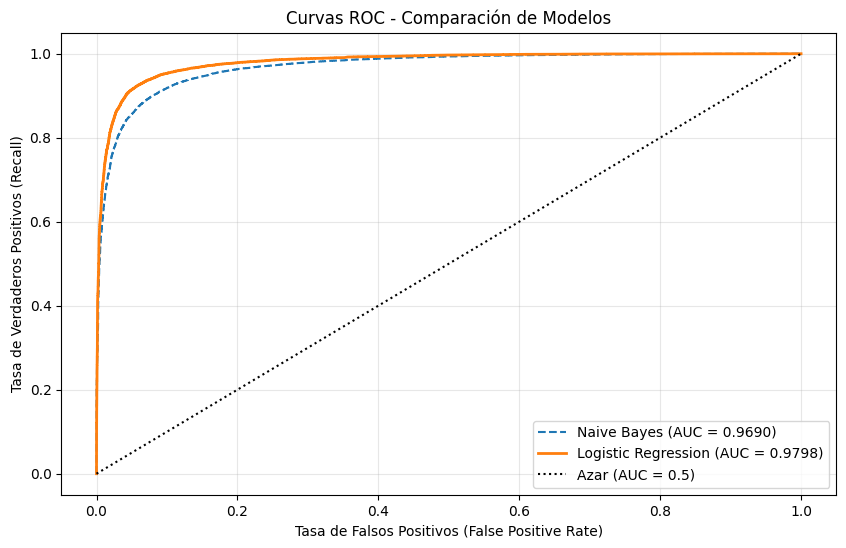

In [13]:
# CÉLULA 2 MEJORADA: Modelos Clásicos + Learning Curves (COSTO) + ROC Curves + Matrices de Confusión
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import time

results = {}

def plot_learning_curve(estimator, title, X, y, cv=5):
    """Genera curva de aprendizaje basada en Función de Costo (Log Loss)"""
    print(f"   📉 Generando gráfica de Costo para: {title}...")
    
    # Usamos 'neg_log_loss'. Scikit-learn usa valores negativos porque optimiza maximizando.
    # El costo real es el valor positivo de esto.
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_log_loss'
    )
    
    # Invertimos el signo (-) para graficar el Costo positivo (Log Loss)
    # Menor valor = Mejor modelo
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Cost (Log Loss)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Cost (Log Loss)")
    
    plt.title(f"{title}\n(Menor es mejor)")
    plt.xlabel("Ejemplos de entrenamiento")
    plt.ylabel("Costo (Log Loss)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# ---------------------------------------------------------
# 1. NAIVE BAYES (Simple, sin mucho tuning)
# ---------------------------------------------------------
print("\n🤖 1. Entrenando Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_val)

acc_nb = accuracy_score(y_val, y_pred_nb)
f1_nb = f1_score(y_val, y_pred_nb)
recall_nb = recall_score(y_val, y_pred_nb)

print(f"✅ Naive Bayes - Acc: {acc_nb:.4f} | F1: {f1_nb:.4f} | Recall: {recall_nb:.4f}")
results['Naive Bayes'] = {'model': nb_model, 'accuracy': acc_nb, 'f1_score': f1_nb, 'recall': recall_nb}

# Gráfica Learning Curve para Naive Bayes (COSTO)
plot_learning_curve(nb_model, "Curva de Aprendizaje - Naive Bayes", X_train, y_train)

# --- NUEVO: Matriz de Confusión para Naive Bayes ---
print("\n📑 Matriz de Confusión (Naive Bayes):")
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_nb, display_labels=['No Suicidio', 'Suicidio'], cmap='Blues')
plt.title("Matriz de Confusión - Naive Bayes")
plt.show()

# ---------------------------------------------------------
# 2. LOGISTIC REGRESSION CON GRID SEARCH (Optimización Profesional)
# ---------------------------------------------------------
print("\n🤖 2. Optimizando Logistic Regression (GridSearch)...")
start_time = time.time()

# Definimos una rejilla de valores para probar
param_grid = {
    'C': [0.1, 1, 10],            # Fuerza de regularización
    'solver': ['liblinear'],      # Buen solver para datasets medianos
    'penalty': ['l2']             # Tipo de penalización estándar
}

# Mantenemos scoring='f1' para la selección del mejor modelo (GridSearch)
grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                    param_grid, 
                    cv=3,             # Validación cruzada de 3 pliegues
                    scoring='f1',     # Optimizamos para F1
                    n_jobs=-1,        # Usar todos los procesadores
                    verbose=1)

grid.fit(X_train, y_train)
best_lr = grid.best_estimator_

train_time = time.time() - start_time
print(f"✅ Búsqueda terminada en {train_time:.2f}s")
print(f"   🏆 Mejores parámetros: {grid.best_params_}")

# Predicción con el modelo GANADOR
y_pred_lr = best_lr.predict(X_val)
acc_lr = accuracy_score(y_val, y_pred_lr)
f1_lr = f1_score(y_val, y_pred_lr)
recall_lr = recall_score(y_val, y_pred_lr)

print(f"   📊 Accuracy: {acc_lr:.4f}")
print(f"   📊 F1-Score: {f1_lr:.4f}")
print(f"   ⚠️ Recall (Suicidio): {recall_lr:.4f} (¡Crítico para este proyecto!)")

results['Logistic Regression'] = {'model': best_lr, 'accuracy': acc_lr, 'f1_score': f1_lr}

# ---------------------------------------------------------
# 3. VISUALIZACIÓN DE ERRORES (Logistic Regression)
# ---------------------------------------------------------
print("\n📉 Generando Curva de Aprendizaje para Logistic Regression (COSTO)...")
plot_learning_curve(best_lr, "Curva de Aprendizaje - Logistic Regression", X_train, y_train)

print("\n📑 Matriz de Confusión (Logistic Regression):")
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_lr, display_labels=['No Suicidio', 'Suicidio'], cmap='Blues')
plt.title("Matriz de Confusión - Logistic Regression")
plt.show()

# ---------------------------------------------------------
# 4. CURVAS ROC - AUC (COMPARACIÓN FINAL)
# ---------------------------------------------------------
print("\n📈 Generando Comparación ROC Curves...")

# Obtener probabilidades (necesarias para ROC) de la clase positiva (índice 1)
y_prob_nb = nb_model.predict_proba(X_val)[:, 1]
y_prob_lr = best_lr.predict_proba(X_val)[:, 1]

# Calcular AUC
auc_nb = roc_auc_score(y_val, y_prob_nb)
auc_lr = roc_auc_score(y_val, y_prob_lr)

# Calcular puntos de la curva
fpr_nb, tpr_nb, _ = roc_curve(y_val, y_prob_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_prob_lr)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, linestyle='--', label=f'Naive Bayes (AUC = {auc_nb:.4f})')
plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], 'k:', label='Azar (AUC = 0.5)') # Línea diagonal

plt.title('Curvas ROC - Comparación de Modelos')
plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()



In [27]:
import joblib
joblib.dump(nb_model, 'modelo_suicidio_nb.pkl') 
print("✅ Modelo guardado como 'modelo_suicidio_nb.pkl'")

joblib.dump(best_lr, 'modelo_suicidio_lr.pkl') 
print("✅ Modelo guardado como 'modelo_suicidio_lr.pkl'")

✅ Modelo guardado como 'modelo_suicidio_nb.pkl'
✅ Modelo guardado como 'modelo_suicidio_lr.pkl'


# Conclusión
Podemos concluir que los dos modelos tuvieron un accuracy muy bueno, arriba de 89, pero para la aplicación, podemos observar que naive bayes, maneja mejor los falsos negativosm teniendo un Recall de 0.9478 pero es un "trade off", porque su número de falsos positivos es mayor.
En cambio logística regresión, tiene un mayor balance entre falsos positivos y negativos, con un recall de 0.9254, pero con mejor F1 y accuracy.

# Red Neuronal (Deep Learning)


🧠 Configurando Red Neuronal...
✅ Conversión a denso exitosa.


/Users/hectorcabrald/Documents/Mis documentos/1 TRABAJOS HECTOR/Universidad/9vo semestre/Curso posgrado Inteligencia artificial/Proyecto_final/suicide_depression_detection/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


🔥 Entrenando Red Neuronal...
Epoch 1/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 172s 32ms/step - accuracy: 0.9265 - loss: 0.1982 - val_accuracy: 0.9333 - val_loss: 0.1748
Epoch 2/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 192s 38ms/step - accuracy: 0.9404 - loss: 0.1587 - val_accuracy: 0.9360 - val_loss: 0.1742
Epoch 3/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 188s 35ms/step - accuracy: 0.9488 - loss: 0.1406 - val_accuracy: 0.9356 - val_loss: 0.1727
Epoch 4/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 174s 34ms/step - accuracy: 0.9575 - loss: 0.1207 - val_accuracy: 0.9350 - val_loss: 0.1814
Epoch 5/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 148s 29ms/step - accuracy: 0.9647 - loss: 0.1026 - val_accuracy: 0.9342 - val_loss: 0.1967
Epoch 6/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 153s 30ms/step - accuracy: 0.9696 - loss: 0.0889 - val_accuracy: 0.9340 - val_loss: 0.2049

📊 Evaluando modelo...
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step

✅ Neural Network completada en 1102.40s
   🎯 Accuracy (Val): 0.9356
   🎯 F1-Score (Val): 0.9355
   ⚠️ R

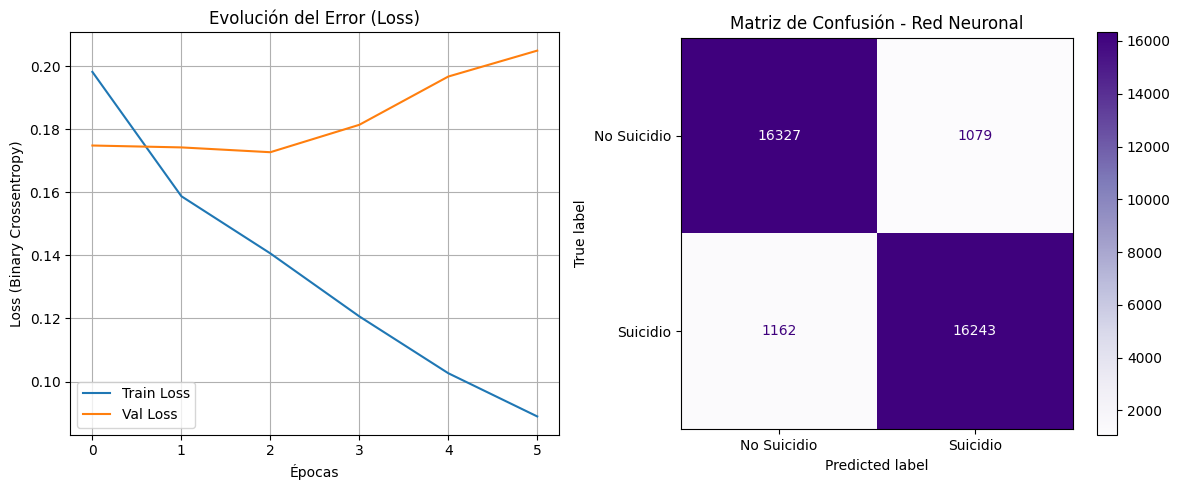

In [23]:
# CÉLULA 3: Red Neuronal (MLP) RELU con Métricas Completas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time

print("\n🧠 Configurando Red Neuronal...")

# Las redes neuronales en Keras prefieren matrices densas
# Si tienes mucha RAM (>16GB), puedes convertir todo. Si no, usa batches.
# Para 5000 features, convertir a denso suele ser seguro en Colab.
try:
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    print("✅ Conversión a denso exitosa.")
except Exception as e:
    print(f"⚠️ Error convirtiendo a denso (falta RAM?): {e}")

def build_neural_network(input_dim):
    model = Sequential([
        # Capa de entrada (5000 neuronas -> 64 neuronas)
        Dense(64, input_dim=input_dim, activation='relu'),
        Dropout(0.3), # Regularización para evitar Overfitting
        
        # Capa oculta
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        # Capa de salida (1 neurona, sigmoide para binario 0/1)
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_nn = build_neural_network(X_train.shape[1])
model_nn.summary()

# Callbacks para detener si no mejora (Evita Overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🔥 Entrenando Red Neuronal...")
start_time = time.time()

history = model_nn.fit(
    X_train_dense, y_train,
    epochs=20,           # Máximo de épocas (parará antes por early_stopping)
    batch_size=32,       # Ajustar según memoria
    validation_data=(X_val_dense, y_val),
    callbacks=[early_stopping],
    verbose=1
)

train_time = time.time() - start_time

# ---------------------------------------------------------
# EVALUACIÓN Y MÉTRICAS
# ---------------------------------------------------------
print("\n📊 Evaluando modelo...")
# Predicción (probabilidades)
y_pred_prob = model_nn.predict(X_val_dense)
# Convertir probabilidad a clase (Umbral 0.5)
y_pred_nn = (y_pred_prob > 0.5).astype(int).flatten()

# Cálculo de métricas
acc_nn = accuracy_score(y_val, y_pred_nn)
f1_nn = f1_score(y_val, y_pred_nn)
recall_nn = recall_score(y_val, y_pred_nn)

# Guardar en diccionario de resultados
results['Neural Network'] = {
    'model': model_nn,
    'accuracy': acc_nn,
    'f1_score': f1_nn,
    'recall': recall_nn,
    'time': train_time,
    'history': history
}

print(f"\n✅ Neural Network completada en {train_time:.2f}s")
print(f"   🎯 Accuracy (Val): {acc_nn:.4f}")
print(f"   🎯 F1-Score (Val): {f1_nn:.4f}")
print(f"   ⚠️ Recall (Val):   {recall_nn:.4f}")

# ---------------------------------------------------------
# VISUALIZACIÓN
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# 1. Gráfica de Pérdida (Loss) durante el entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución del Error (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)

# 2. Matriz de Confusión
plt.subplot(1, 2, 2)
# Usamos el array de la matriz para graficarlo manualmente o con display
cm = confusion_matrix(y_val, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Suicidio', 'Suicidio'])
disp.plot(cmap='Purples', ax=plt.gca()) # Usamos morado para distinguir de los otros
plt.title('Matriz de Confusión - Red Neuronal')

plt.tight_layout()
plt.show()

Prueba final con test


🧪 Evaluando con conjunto de TEST (Datos nunca vistos)...
✅ Conversión de Test a denso exitosa.
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step

🏆 RESULTADOS FINALES (TEST SET):
   Accuracy: 0.9377
   Recall:   0.9369
   F1-Score: 0.9377


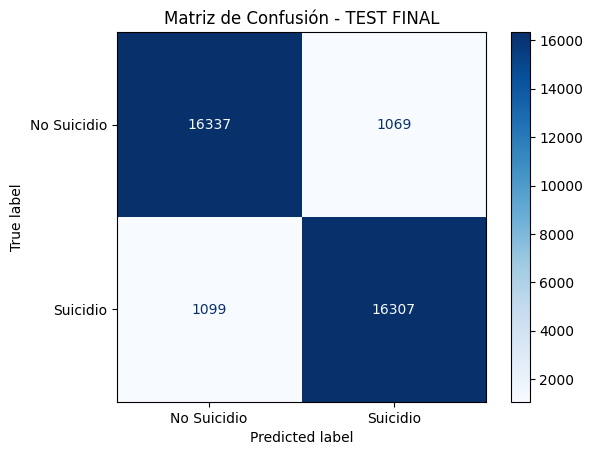

In [26]:
# ---------------------------------------------------------
# EVALUACIÓN FINAL CON TEST (La prueba de fuego)
# ---------------------------------------------------------
print("\n🧪 Evaluando con conjunto de TEST (Datos nunca vistos)...")

# 1. Cargar y preparar datos de Test (asumiendo que ya cargaste X_test sparse arriba)
# Nota: Asegúrate de haber cargado X_test y y_test previamente con load_data o similar
try:
    # Si X_test no está cargado en memoria, cárgalo aquí (ajusta la ruta si es necesario)
    # X_test = scipy.sparse.load_npz('processed_data/X_test_tfidf.npz')
    # y_test = np.load('processed_data/y_test.npy')
    
    X_test_dense = X_test.toarray() # Convertir a denso igual que train/val
    print("✅ Conversión de Test a denso exitosa.")
except Exception as e:
    print(f"⚠️ Error/Atención con datos de Test: {e}")

# 2. Predicción Final
y_pred_test_prob = model_nn.predict(X_test_dense)
y_pred_test = (y_pred_test_prob > 0.5).astype(int).flatten()

# 3. Métricas de Test
acc_test = accuracy_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"\n🏆 RESULTADOS FINALES (TEST SET):")
print(f"   Accuracy: {acc_test:.4f}")
print(f"   Recall:   {rec_test:.4f}")
print(f"   F1-Score: {f1_test:.4f}")

# Opcional: Matriz de confusión de Test
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['No Suicidio', 'Suicidio'])
disp_test.plot(cmap='Blues') # Azul para diferenciar de validación
plt.title('Matriz de Confusión - TEST FINAL')
plt.show()

In [25]:
import joblib
joblib.dump(model_nn, 'modelo_suicidio.pkl') 
print("✅ Modelo guardado como 'modelo_suicidio.pkl'")

✅ Modelo guardado como 'modelo_suicidio.pkl'



🧠 Configurando Red Neuronal...
✅ Conversión a denso exitosa.


/Users/hectorcabrald/Documents/Mis documentos/1 TRABAJOS HECTOR/Universidad/9vo semestre/Curso posgrado Inteligencia artificial/Proyecto_final/suicide_depression_detection/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


🔥 Entrenando Red Neuronal...
Epoch 1/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.9272 - loss: 0.1951 - val_accuracy: 0.9327 - val_loss: 0.1789
Epoch 2/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.9361 - loss: 0.1674 - val_accuracy: 0.9336 - val_loss: 0.1752
Epoch 3/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - accuracy: 0.9384 - loss: 0.1595 - val_accuracy: 0.9339 - val_loss: 0.1747
Epoch 4/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - accuracy: 0.9398 - loss: 0.1547 - val_accuracy: 0.9335 - val_loss: 0.1782
Epoch 5/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.9412 - loss: 0.1512 - val_accuracy: 0.9334 - val_loss: 0.1778
Epoch 6/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.9423 - loss: 0.1475 - val_accuracy: 0.9342 - val_loss: 0.1782

📊 Evaluando modelo...
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

✅ Neural Network completada en 301.81s
   🎯 Accuracy (Val): 0.9339
   🎯 F1-Score (Val): 0.9338
   ⚠️ Recall (Val): 

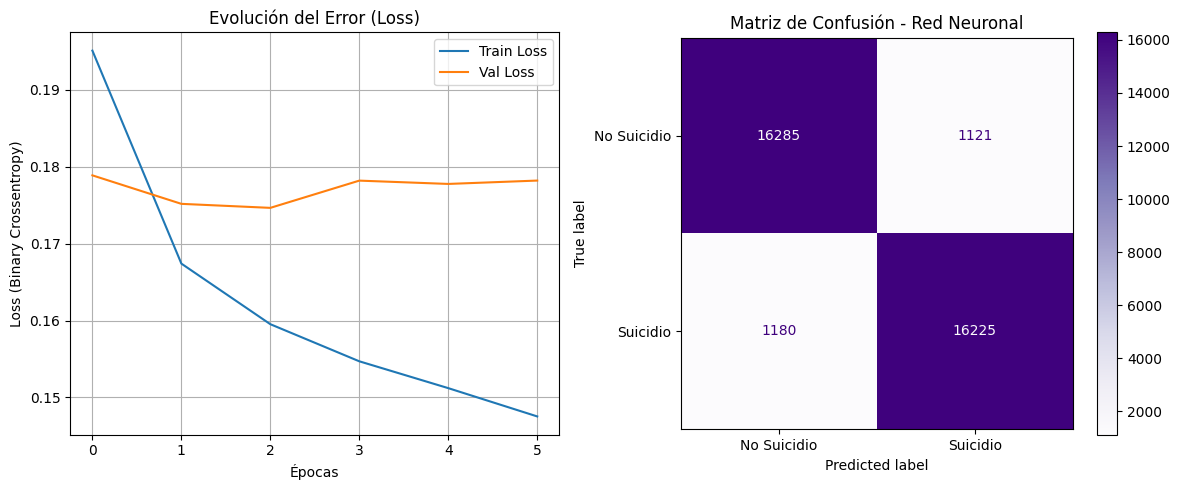

In [ ]:
# CÉLULA 3: Red Neuronal (MLP) GELU con Métricas Completas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time

print("\n🧠 Configurando Red Neuronal (GELU)...")

# Conversión de datos (Esto se puede reusar, no necesita nombre único si los datos son los mismos)
try:
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    print("✅ Conversión a denso exitosa.")
except Exception as e:
    print(f"⚠️ Error convirtiendo a denso: {e}")

# Renombramos la función para que sea específica de GELU
def build_model_gelu(input_dim):
    model = Sequential([
        # Capa de entrada
        Dense(64, input_dim=input_dim, activation='gelu'),
        Dropout(0.3), 
        
        # Capa oculta
        Dense(32, activation='gelu'),
        Dropout(0.2),
        
        # Capa de salida
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Instanciamos el modelo con nombre único
model_gelu = build_model_gelu(X_train.shape[1])
model_gelu.summary()

# Callback específico
early_stopping_gelu = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🔥 Entrenando Red Neuronal GELU...")
start_time_gelu = time.time()

# Guardamos el historial en variable única
history_gelu = model_gelu.fit(
    X_train_dense, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_dense, y_val),
    callbacks=[early_stopping_gelu],
    verbose=1
)

train_time_gelu = time.time() - start_time_gelu

# ---------------------------------------------------------
# EVALUACIÓN Y MÉTRICAS (GELU)
# ---------------------------------------------------------
print("\n📊 Evaluando modelo GELU...")
# Predicción
y_pred_prob_gelu = model_gelu.predict(X_val_dense)
y_pred_gelu = (y_pred_prob_gelu > 0.5).astype(int).flatten()

# Cálculo de métricas específicas
acc_gelu = accuracy_score(y_val, y_pred_gelu)
f1_gelu = f1_score(y_val, y_pred_gelu)
recall_gelu = recall_score(y_val, y_pred_gelu)

# Guardar en diccionario con CLAVE ÚNICA
results['MLP_GELU'] = {
    'model': model_gelu,
    'accuracy': acc_gelu,
    'f1_score': f1_gelu,
    'recall': recall_gelu,
    'time': train_time_gelu,
    'history': history_gelu
}

print(f"\n✅ Neural Network (GELU) completada en {train_time_gelu:.2f}s")
print(f"   🎯 Accuracy (Val): {acc_gelu:.4f}")
print(f"   🎯 F1-Score (Val): {f1_gelu:.4f}")
print(f"   ⚠️ Recall (Val):   {recall_gelu:.4f}")

# ---------------------------------------------------------
# VISUALIZACIÓN
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# 1. Gráfica de Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_gelu.history['loss'], label='Train Loss')
plt.plot(history_gelu.history['val_loss'], label='Val Loss')
plt.title('Evolución del Error - GELU')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Matriz de Confusión
plt.subplot(1, 2, 2)
cm_gelu = confusion_matrix(y_val, y_pred_gelu)
disp_gelu = ConfusionMatrixDisplay(confusion_matrix=cm_gelu, display_labels=['No Suicidio', 'Suicidio'])
disp_gelu.plot(cmap='Purples', ax=plt.gca()) 
plt.title('Matriz de Confusión - GELU')

plt.tight_layout()
plt.show()


🧠 Configurando Red Neuronal...
✅ Conversión a denso exitosa.


/Users/hectorcabrald/Documents/Mis documentos/1 TRABAJOS HECTOR/Universidad/9vo semestre/Curso posgrado Inteligencia artificial/Proyecto_final/suicide_depression_detection/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/hectorcabrald/Documents/Mis documentos/1 TRABAJOS HECTOR/Universidad/9vo semestre/Curso posgrado Inteligencia artificial/Proyecto_final/suicide_depression_detection/venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


🔥 Entrenando Red Neuronal...
Epoch 1/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9253 - loss: 0.1972 - val_accuracy: 0.9329 - val_loss: 0.1766
Epoch 2/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - accuracy: 0.9395 - loss: 0.1606 - val_accuracy: 0.9359 - val_loss: 0.1725
Epoch 3/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.9477 - loss: 0.1424 - val_accuracy: 0.9359 - val_loss: 0.1744
Epoch 4/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - accuracy: 0.9560 - loss: 0.1236 - val_accuracy: 0.9349 - val_loss: 0.1796
Epoch 5/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - accuracy: 0.9630 - loss: 0.1069 - val_accuracy: 0.9346 - val_loss: 0.1910

📊 Evaluando modelo...
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

✅ Neural Network completada en 279.32s
   🎯 Accuracy (Val): 0.9359
   🎯 F1-Score (Val): 0.9355
   ⚠️ Recall (Val):   0.9291


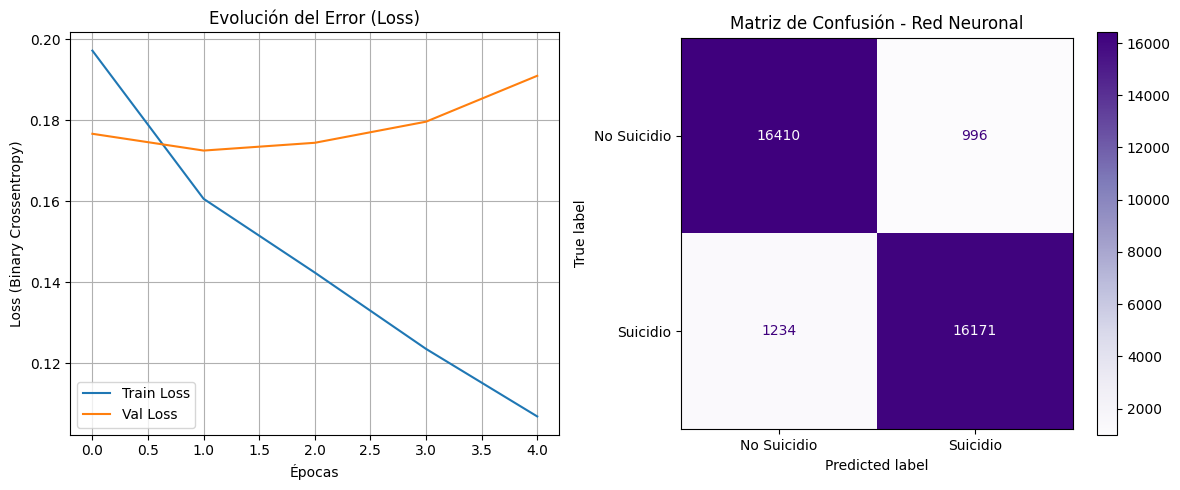

In [ ]:
# CÉLULA 3 (B): Red Neuronal (MLP) LeakyReLU con Métricas Completas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU # Importante importar LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import time

print("\n🧠 Configurando Red Neuronal (LeakyReLU)...")

# Conversión a denso (si ya se hizo arriba, esto solo confirma)
try:
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    print("✅ Conversión a denso verificada.")
except Exception as e:
    print(f"⚠️ Error/Nota sobre conversión a denso: {e}")

# Definimos la función con nombre único
def build_model_leaky(input_dim):
    model = Sequential([
        # Capa de entrada (5000 -> 64)
        Dense(64, input_dim=input_dim), # Nota: Sin activación aquí porque viene la capa LeakyReLU abajo
        LeakyReLU(alpha=0.01),          # Activación como capa separada
        Dropout(0.3),            
        
        # Capa oculta
        Dense(32),
        LeakyReLU(alpha=0.01),          # Activación LeakyReLU
        Dropout(0.2),
        
        # Capa de salida (Sigmoide siempre va igual para binario)
        Dense(1, activation='sigmoid') 
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instanciamos el modelo LEAKY
model_leaky = build_model_leaky(X_train.shape[1])
model_leaky.summary()

# Callback específico
early_stopping_leaky = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🔥 Entrenando Red Neuronal LeakyReLU...")
start_time_leaky = time.time()

# Guardamos historial en variable única
history_leaky = model_leaky.fit(
    X_train_dense, y_train,
    epochs=20,           
    batch_size=32,       
    validation_data=(X_val_dense, y_val),
    callbacks=[early_stopping_leaky],
    verbose=1
)

train_time_leaky = time.time() - start_time_leaky

# ---------------------------------------------------------
# EVALUACIÓN Y MÉTRICAS (LEAKY)
# ---------------------------------------------------------
print("\n📊 Evaluando modelo LeakyReLU...")
# Predicción
y_pred_prob_leaky = model_leaky.predict(X_val_dense)
y_pred_leaky = (y_pred_prob_leaky > 0.5).astype(int).flatten()

# Cálculo de métricas
acc_leaky = accuracy_score(y_val, y_pred_leaky)
f1_leaky = f1_score(y_val, y_pred_leaky)
recall_leaky = recall_score(y_val, y_pred_leaky)

# Guardar en diccionario con CLAVE ÚNICA
results['MLP_Leaky'] = {
    'model': model_leaky,
    'accuracy': acc_leaky,
    'f1_score': f1_leaky,
    'recall': recall_leaky,
    'time': train_time_leaky,
    'history': history_leaky
}

print(f"\n✅ Neural Network (LeakyReLU) completada en {train_time_leaky:.2f}s")
print(f"   🎯 Accuracy (Val): {acc_leaky:.4f}")
print(f"   🎯 F1-Score (Val): {f1_leaky:.4f}")
print(f"   ⚠️ Recall (Val):   {recall_leaky:.4f}")

# ---------------------------------------------------------
# VISUALIZACIÓN
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# 1. Gráfica de Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_leaky.history['loss'], label='Train Loss')
plt.plot(history_leaky.history['val_loss'], label='Val Loss')
plt.title('Evolución del Error - LeakyReLU')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Matriz de Confusión
plt.subplot(1, 2, 2)
cm_leaky = confusion_matrix(y_val, y_pred_leaky)
disp_leaky = ConfusionMatrixDisplay(confusion_matrix=cm_leaky, display_labels=['No Suicidio', 'Suicidio'])
# Usamos naranjas para distinguir de la anterior (GELU era morado)
disp_leaky.plot(cmap='Oranges', ax=plt.gca()) 
plt.title('Matriz de Confusión - LeakyReLU')

plt.tight_layout()
plt.show()


🧠 Configurando Red Neuronal (implementación propia con NumPy)...
✅ Conversión a denso exitosa.

Arquitectura del modelo:
Entrada: 5000 -> Capa1: 64 ReLU -> Capa2: 32 ReLU -> Salida: 1 Sigmoid
Dropout: 0.3 en capa 1, 0.2 en capa 2

🔥 Entrenando Red Neuronal (NumPy)...
Epoch 01 - loss: 0.6933 - val_loss: 0.6934
Epoch 02 - loss: 0.6933 - val_loss: 0.6940
Epoch 03 - loss: 0.6948 - val_loss: 0.6976
Epoch 04 - loss: 0.7028 - val_loss: 0.7135
⏹ Early stopping activado en epoch 4

📊 Evaluando modelo...

✅ Neural Network (NumPy) completada en 780.03s
   🎯 Accuracy (Val): 0.5943
   🎯 F1-Score (Val): 0.7038
   ⚠️ Recall (Val):   0.9640


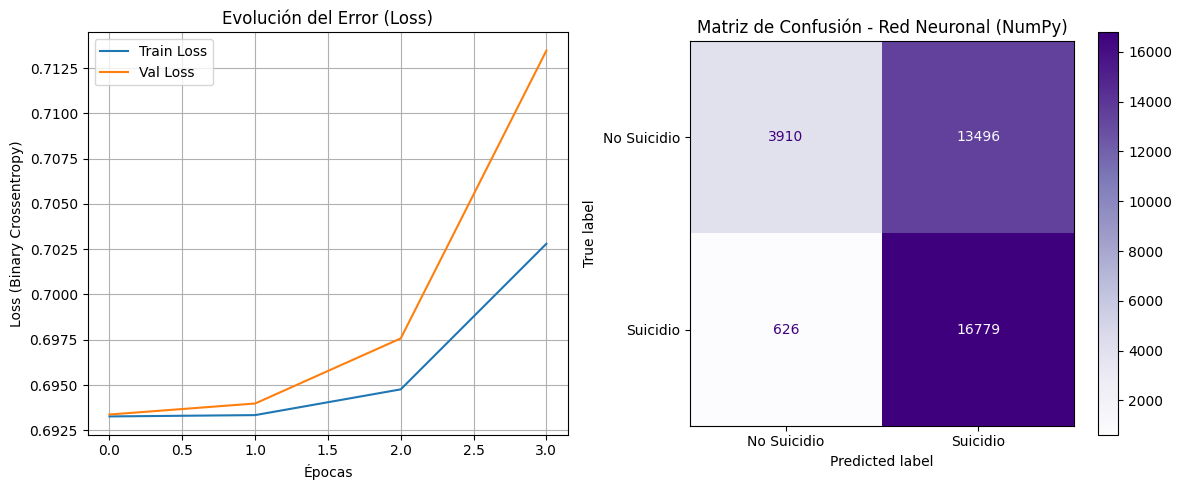

In [21]:
# CÉLULA 3: Red Neuronal (MLP) ReLU con Métricas Completas - SIN TENSORFLOW

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, accuracy_score
import time

print("\n🧠 Configurando Red Neuronal (implementación propia con NumPy)...")

# ------------------------------------------------------------------
# 1. Conversión a matrices densas (igual que antes)
# ------------------------------------------------------------------
try:
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    print("✅ Conversión a denso exitosa.")
except Exception as e:
    print(f"⚠️ Error convirtiendo a denso (falta RAM?): {e}")
    # Si ya son densos, simplemente los usamos directamente
    X_train_dense = np.array(X_train)
    X_val_dense = np.array(X_val)

y_train_array = np.array(y_train).astype(float)
y_val_array   = np.array(y_val).astype(float)

# ------------------------------------------------------------------
# 2. Activaciones y utilidades
# ------------------------------------------------------------------
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    # Evitar overflow numérico
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def binary_crossentropy(y_true, y_pred):
    eps = 1e-10
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


# ------------------------------------------------------------------
# 3. Clase: MLP desde cero con NumPy
#    Arquitectura: 5000 -> 64 -> 32 -> 1 (ReLU + Sigmoid)
# ------------------------------------------------------------------
class NumpyMLP:
    def __init__(self, input_dim, hidden1=64, hidden2=32,
                 lr=1e-3, dropout1=0.3, dropout2=0.2,
                 l2=0.0, random_state=42):
        rng = np.random.default_rng(random_state)

        # Pesos inicializados tipo Xavier/He sencillo
        self.W1 = rng.normal(0, np.sqrt(2 / input_dim), size=(input_dim, hidden1))
        self.b1 = np.zeros(hidden1)

        self.W2 = rng.normal(0, np.sqrt(2 / hidden1), size=(hidden1, hidden2))
        self.b2 = np.zeros(hidden2)

        self.W3 = rng.normal(0, np.sqrt(2 / hidden2), size=(hidden2, 1))
        self.b3 = np.zeros(1)

        self.lr = lr
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.l2 = l2

        self.train_losses = []
        self.val_losses = []

    def _forward(self, X, train=False):
        # Capa 1
        z1 = X @ self.W1 + self.b1
        a1 = relu(z1)

        mask1 = None
        if train and self.dropout1 > 0.0:
            mask1 = (np.random.rand(*a1.shape) >= self.dropout1) / (1.0 - self.dropout1)
            a1 = a1 * mask1

        # Capa 2
        z2 = a1 @ self.W2 + self.b2
        a2 = relu(z2)

        mask2 = None
        if train and self.dropout2 > 0.0:
            mask2 = (np.random.rand(*a2.shape) >= self.dropout2) / (1.0 - self.dropout2)
            a2 = a2 * mask2

        # Capa salida
        z3 = a2 @ self.W3 + self.b3
        y_hat = sigmoid(z3)

        cache = (X, z1, a1, mask1, z2, a2, mask2, z3, y_hat)
        return y_hat, cache

    def _backward(self, cache, y_true):
        X, z1, a1, mask1, z2, a2, mask2, z3, y_hat = cache
        m = X.shape[0]

        # Asegurar que y_true sea columna
        y_true = y_true.reshape(-1, 1)

        # Derivadas capa salida (sigmoid + BCE)
        dZ3 = (y_hat - y_true)  # (m, 1)
        dW3 = (a2.T @ dZ3) / m
        db3 = dZ3.mean(axis=0)

        # L2 para W3
        if self.l2 > 0:
            dW3 += (self.l2 / m) * self.W3

        # Propagación hacia atrás a capa 2
        dA2 = dZ3 @ self.W3.T  # (m, hidden2)
        if mask2 is not None:
            dA2 *= mask2
        dZ2 = dA2 * relu_derivative(z2)
        dW2 = (a1.T @ dZ2) / m
        db2 = dZ2.mean(axis=0)

        if self.l2 > 0:
            dW2 += (self.l2 / m) * self.W2

        # Propagación hacia atrás a capa 1
        dA1 = dZ2 @ self.W2.T  # (m, hidden1)
        if mask1 is not None:
            dA1 *= mask1
        dZ1 = dA1 * relu_derivative(z1)
        dW1 = (X.T @ dZ1) / m
        db1 = dZ1.mean(axis=0)

        if self.l2 > 0:
            dW1 += (self.l2 / m) * self.W1

        # Actualización de pesos
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def fit(self, X_train, y_train, X_val=None, y_val=None,
            epochs=20, batch_size=32, patience=3, verbose=1):

        n_samples = X_train.shape[0]
        best_val_loss = np.inf
        best_params = None
        patience_counter = 0

        for epoch in range(1, epochs + 1):
            # Barajar datos
            idx = np.random.permutation(n_samples)
            X_train = X_train[idx]
            y_train = y_train[idx]

            epoch_loss = 0.0
            n_batches = int(np.ceil(n_samples / batch_size))

            for i in range(n_batches):
                start = i * batch_size
                end = min((i + 1) * batch_size, n_samples)

                X_batch = X_train[start:end]
                y_batch = y_train[start:end]

                # Forward
                y_hat, cache = self._forward(X_batch, train=True)
                loss = binary_crossentropy(y_batch, y_hat)
                epoch_loss += loss

                # Backward
                self._backward(cache, y_batch)

            epoch_loss /= n_batches
            self.train_losses.append(epoch_loss)

            # Validación
            if X_val is not None and y_val is not None:
                y_val_pred, _ = self._forward(X_val, train=False)
                val_loss = binary_crossentropy(y_val, y_val_pred)
                self.val_losses.append(val_loss)
            else:
                val_loss = None

            if verbose:
                if val_loss is not None:
                    print(f"Epoch {epoch:02d} - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch:02d} - loss: {epoch_loss:.4f}")

            # Early Stopping por val_loss
            if val_loss is not None:
                if val_loss < best_val_loss - 1e-5:
                    best_val_loss = val_loss
                    best_params = (
                        self.W1.copy(), self.b1.copy(),
                        self.W2.copy(), self.b2.copy(),
                        self.W3.copy(), self.b3.copy()
                    )
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        if verbose:
                            print(f"⏹ Early stopping activado en epoch {epoch}")
                        break

        # Restaurar mejores pesos
        if best_params is not None:
            self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = best_params

        # Objeto tipo "History" para mantener compatibilidad con tu código
        class SimpleHistory:
            def __init__(self, losses, val_losses):
                self.history = {
                    'loss': losses,
                    'val_loss': val_losses
                }

        return SimpleHistory(self.train_losses, self.val_losses)

    def predict_proba(self, X):
        y_hat, _ = self._forward(X, train=False)
        return y_hat.ravel()

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba > threshold).astype(int)


# ------------------------------------------------------------------
# 4. Crear y "resumir" el modelo
# ------------------------------------------------------------------
input_dim = X_train_dense.shape[1]
model_nn = NumpyMLP(
    input_dim=input_dim,
    hidden1=64,
    hidden2=32,
    lr=1e-3,
    dropout1=0.3,
    dropout2=0.2,
    l2=0.0
)

print("\nArquitectura del modelo:")
print(f"Entrada: {input_dim} -> Capa1: 64 ReLU -> Capa2: 32 ReLU -> Salida: 1 Sigmoid")
print("Dropout: 0.3 en capa 1, 0.2 en capa 2")

# ------------------------------------------------------------------
# 5. Entrenamiento
# ------------------------------------------------------------------
print("\n🔥 Entrenando Red Neuronal (NumPy)...")
start_time = time.time()

history = model_nn.fit(
    X_train_dense, y_train_array,
    X_val=X_val_dense, y_val=y_val_array,
    epochs=20,
    batch_size=32,
    patience=3,
    verbose=1
)

train_time = time.time() - start_time

# ------------------------------------------------------------------
# 6. Evaluación y métricas
# ------------------------------------------------------------------
print("\n📊 Evaluando modelo...")
y_pred_prob = model_nn.predict_proba(X_val_dense)
y_pred_nn = model_nn.predict(X_val_dense, threshold=0.5)

acc_nn = accuracy_score(y_val_array, y_pred_nn)
f1_nn = f1_score(y_val_array, y_pred_nn)
recall_nn = recall_score(y_val_array, y_pred_nn)

# Aseguramos que 'results' exista
try:
    results
except NameError:
    results = {}

results['Neural Network (NumPy)'] = {
    'model': model_nn,
    'accuracy': acc_nn,
    'f1_score': f1_nn,
    'recall': recall_nn,
    'time': train_time,
    'history': history
}

print(f"\n✅ Neural Network (NumPy) completada en {train_time:.2f}s")
print(f"   🎯 Accuracy (Val): {acc_nn:.4f}")
print(f"   🎯 F1-Score (Val): {f1_nn:.4f}")
print(f"   ⚠️ Recall (Val):   {recall_nn:.4f}")

# ------------------------------------------------------------------
# 7. Visualización
# ------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# 1. Gráfica de Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
if len(history.history['val_loss']) > 0:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución del Error (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)

# 2. Matriz de Confusión
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_val_array, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Suicidio', 'Suicidio'])
disp.plot(cmap='Purples', ax=plt.gca())
plt.title('Matriz de Confusión - Red Neuronal (NumPy)')

plt.tight_layout()
plt.show()
